<a href="https://colab.research.google.com/github/navyaboddapati/LLM--Detect-AI-Generated-Text/blob/main/LLM_Detect_AI_Generated_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'navyaboddapati'
os.environ['KAGGLE_KEY'] = '3d801ca7ef63201eb65ce89d7af7db3d'

In [ ]:
!kaggle competitions download -c llm-detect-ai-generated-text

 72% 1.00M/1.38M [00:00<00:00, 1.48MB/s]
100% 1.38M/1.38M [00:00<00:00, 1.91MB/s]


In [ ]:
!unzip llm-detect-ai-generated-text.zip

Archive:  llm-detect-ai-generated-text.zip
  inflating: sample_submission.csv   
  inflating: test_essays.csv         
  inflating: train_essays.csv        
  inflating: train_prompts.csv       


In [ ]:
import pandas as pd

In [ ]:
# Loading the data
train_data = pd.read_csv('train_essays.csv')
test_data = pd.read_csv('test_essays.csv')

In [ ]:
print('Head train data : ')
print(train_data.head())
print('I\nnfo: ')
print(train_data.info())
print('\nDescribe data: ')
print(train_data.describe())

Head train data : 
         id  prompt_id                                               text  \
0  0059830c          0  Cars. Cars have been around since they became ...   
1  005db917          0  Transportation is a large necessity in most co...   
2  008f63e3          0  "America's love affair with it's vehicles seem...   
3  00940276          0  How often do you ride in a car? Do you drive a...   
4  00c39458          0  Cars are a wonderful thing. They are perhaps o...   

   generated  
0          0  
1          0  
2          0  
3          0  
4          0  
I
nfo: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None

Describe data: 
       

In [ ]:
# finding no. of records
num_records = len(train_data)
print(f'Number of Records: {num_records}')

Number of Records: 1378


In [ ]:
# no. of null values in the data
null_counts = train_data.isnull().sum()
print(f'Number of Null Values:{null_counts}')

Number of Null Values:id           0
prompt_id    0
text         0
generated    0
dtype: int64


In [ ]:
'''df1 = pd.read_csv('train_essays.csv')
df2 = pd.read_csv('train_prompts.csv')
df = pd.merge(df1,df2,)'''

"df1 = pd.read_csv('train_essays.csv')\ndf2 = pd.read_csv('train_prompts.csv')\ndf = pd.merge(df1,df2,)"

Generated 0: 1375 essays
Generated 1: 3 essays




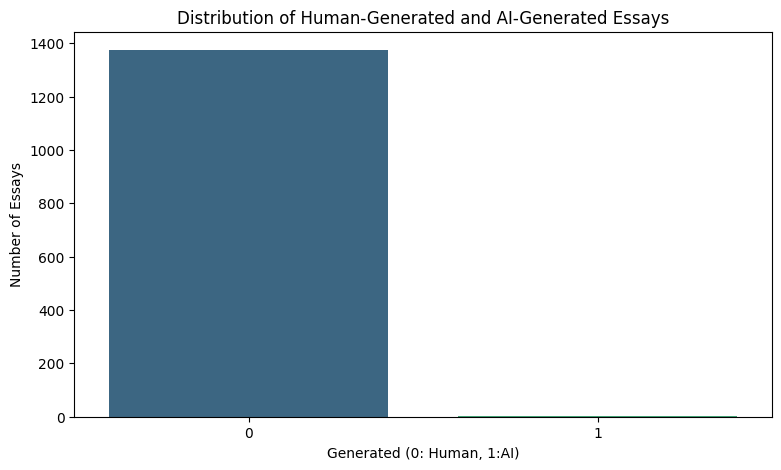

In [ ]:
# checking for how many are human essays and AI generated essays
import matplotlib.pyplot as plt
import seaborn as sns

generated_counts = train_data['generated'].value_counts()

for value,count in generated_counts.items():
  print(f"Generated {value}: { count} essays")

plt.figure(figsize=(9,5))
sns.barplot(x=generated_counts.index, y=generated_counts.values, palette='viridis')
print("\n")
plt.title('Distribution of Human-Generated and AI-Generated Essays')
plt.xlabel('Generated (0: Human, 1:AI)')
plt.ylabel('Number of Essays')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X = train_data['text']
y = train_data['generated']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [ ]:
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk

nltk.download('punkt')

tokenized_essays = [word_tokenize(essay.lower()) for essay in train_data['text']]

all_words = [word for essay_words in tokenized_essays for word in essay_words]

word_counts = Counter(all_words)

vocabulary = [word for word, count in word_counts.items() if count>=5]

reverse_index = {word: idx for idx, word in enumerate(vocabulary)}

print("Vocabulary:" , vocabulary[:10])

print("Reverse Index:" , reverse_index)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Vocabulary: ['cars', '.', 'have', 'been', 'around', 'since', 'they', 'became', 'famous', 'in']
Reverse Index: {'cars': 0, '.': 1, 'have': 2, 'been': 3, 'around': 4, 'since': 5, 'they': 6, 'became': 7, 'famous': 8, 'in': 9, 'the': 10, ',': 11, 'when': 12, 'henry': 13, 'ford': 14, 'created': 15, 'and': 16, 'built': 17, 'first': 18, 'played': 19, 'a': 20, 'major': 21, 'role': 22, 'our': 23, 'every': 24, 'day': 25, 'lives': 26, 'then': 27, 'but': 28, 'now': 29, 'people': 30, 'are': 31, 'starting': 32, 'to': 33, 'question': 34, 'if': 35, 'limiting': 36, 'car': 37, 'usage': 38, 'would': 39, 'be': 40, 'good': 41, 'thing': 42, 'me': 43, 'use': 44, 'of': 45, 'might': 46, 'do': 47, 'like': 48, 'matter': 49, 'this': 50, 'article': 51, '``': 52, 'german': 53, 'suburb': 54, 'life': 55, 'goes': 56, 'on': 57, 'without': 58, "''": 59, 'by': 60, 'elizabeth': 61, 'rosenthal': 62, 'states': 63, 'how': 64, 'automobiles': 65, 'linchpin': 66, 'suburbs': 67, 'where': 68, 'middle': 69, 'class': 70, 'families'

In [ ]:
total_words = len(all_words)
word_occurence_probability = {word: count/total_words for word, count in word_counts.items()}

print("Total words count: ", total_words)
print("Word occurences probability: ",word_occurence_probability)

Total words count:  855744
Word occurences probability:  {'cars': 0.0066959277540946825, '.': 0.04089540797247775, 'have': 0.007577032383516566, 'been': 0.001446694338493755, 'around': 0.0009956248597711465, 'since': 0.0006999756936653952, 'they': 0.00659309326153616, 'became': 3.73943609303717e-05, 'famous': 9.348590232592925e-06, 'in': 0.01921369007553661, 'the': 0.05724258656794556, '1900s': 3.505721337222347e-06, ',': 0.03820885685438636, 'when': 0.002255347393613043, 'henry': 5.8428688953705785e-06, 'ford': 0.00012854311569815272, 'created': 0.00023722047715204548, 'and': 0.020286440804726646, 'built': 0.00010049734500037394, 'first': 0.0005293639219205744, 'modelt': 4.674295116296462e-06, 'played': 1.051716401166704e-05, 'a': 0.02194581557101189, 'major': 0.00028746914965223244, 'role': 6.894585296537282e-05, 'our': 0.0035992072395482763, 'every': 0.0007104928576770623, 'day': 0.0018580323087278438, 'lives': 0.00035407785505945705, 'then': 0.0012083052875626356, 'but': 0.00404677

In [ ]:
def calculate_conditional_probabilities(data, target_class, vocabulary, word_index):
    class_data = data[data['generated'] == target_class]
    total_class_words = [word for essay in class_data['text'] for word in word_tokenize(essay.lower())]

    class_word_counts = Counter(total_class_words)

    conditional_probabilities = {word: class_word_counts[word]/len(total_class_words) for word in vocabulary}

    return  conditional_probabilities

    human_cond_prob = calculate_conditional_probabilities(train_data, 0, vocabulary, word_index)

    llm_cond_prob = calculate_conditional_probabilities(train_data, 1, vocabulary, word_index)


In [ ]:
from concurrent.futures import process
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import numpy as np

labels = train_data['generated'].values

processed_essays = [' '.join(essay) for essay in tokenized_essays]

X_train, X_dev, y_train, y_dev = train_test_split(processed_essays, labels, test_size =0.2, random_state = 42)

X_train_array = np.array(X_train)
X_dev_array = np.array(X_dev)

vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_dev_vectorized = vectorizer.transform(X_dev)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)

dev_predictions = nb_classifier.predict(X_dev_vectorized)

accuracy = accuracy_score(y_dev, dev_predictions)
print(f"Accuracy on the Development set: {accuracy}")

train_predictions = nb_classifier.predict(X_train_vectorized)

train_accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy on the Training set:",train_accuracy)



Accuracy on the Development set: 0.9963768115942029
Accuracy on the Training set: 0.9981851179673321


In [ ]:
alpha_values = [0.1, 0.5, 1.0]
accuracies = []

for alpha in alpha_values:
    nb_classifier = MultinomialNB(alpha = alpha)
    nb_classifier.fit(X_train_vectorized, y_train)
    dev_predictions = nb_classifier.predict(X_dev_vectorized)
    accuracy = accuracy_score(y_dev, dev_predictions)
    accuracies.append(accuracy)
    print(f"Smoothing (alpha={alpha}): Accuracy on Development set: {accuracy}")

feature_names = np.array(vectorizer.get_feature_names_out())
top_predictive_words = {}

for i, class_label in enumerate(nb_classifier.classes_):
    class_probs = nb_classifier.feature_log_prob_[i]
    top_word_indices = np.argsort(class_probs)[::-1][:10]
    top_words = [feature_names[idx] for idx in top_word_indices]
    top_predictive_words[class_label] = top_words
    print(f"Top 10 words predicting class '{class_label}': {top_words}")

optimal_alpha = alpha_values[np.argmax(accuracies)]
print(f"Optimal Smoothing Parameter (aplha): {optimal_alpha}")

# Assuming you have the final trained classifier and the vectorizer
final_nb_classifier = MultinomialNB(alpha=optimal_alpha)
final_nb_classifier.fit(X_train_vectorized, y_train)

# Process the test essays
tokenized_test_essays = [word_tokenize(essay.lower()) for essay in test_data['text']]
processed_test_essays = [' '.join(essay) for essay in tokenized_test_essays]

# Vectorize the test essays using the same vectorizer used for training
X_test_vectorized = vectorizer.transform(processed_test_essays)

# Make predictions on the test dataset
final_test_predictions = final_nb_classifier.predict(X_test_vectorized)

# Prepare submission DataFrame
submission_df = pd.DataFrame({'id': test_data['id'], 'generated': final_test_predictions})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('final_submission.csv', index=False)




Smoothing (alpha=0.1): Accuracy on Development set: 0.9963768115942029
Smoothing (alpha=0.5): Accuracy on Development set: 0.9963768115942029
Smoothing (alpha=1.0): Accuracy on Development set: 0.9963768115942029
Top 10 words predicting class '0': ['the', 'to', 'of', 'and', 'in', 'is', 'electoral', 'that', 'car', 'vote']
Top 10 words predicting class '1': ['the', 'votes', 'electoral', 'state', 'nationally', 'vote', 'of', 'candidate', 'college', 'for']
Optimal Smoothing Parameter (aplha): 0.1
